# Kernel methods for biological sequence classification

MVA 2019 - Kernel methods for machine learning

*Éloïse Berthier, Guillaume Dalle, Clément Mantoux*

In [1]:
import os
import cProfile, pstats
import tqdm
import itertools

import numpy as np
import scipy.sparse as sp
import pandas as pd

import cvxpy as cp
from qpsolvers import solve_qp
import osqp

import matplotlib.pyplot as plt

from vector_kernels import *

Academic license - for non-commercial use only


Reading data

In [2]:
def read_data_mat100(dataset="tr0"):
    folder = "kernel-methods-for-machine-learning-2018-2019"
    features_file = "X" + dataset + "_mat100.csv"
    labels_file = "Y" + dataset + ".csv"
    
    X = pd.read_csv(
        os.path.join(folder, features_file),
        sep=" ",
        header=None
    )
    if "te" in dataset:
        return np.array(X)
    
    elif "tr" in dataset:
        Y = pd.read_csv(
            os.path.join(folder, labels_file),
            sep=",",
            index_col=0,
        )
        return np.array(X), 2 * np.array(Y.iloc[:, 0]) - 1

In [3]:
dataset = []
for k in [0, 1, 2]:
    Xtr, Ytr = read_data_mat100("tr" + str(k))
    Xte = read_data_mat100("te" + str(k))
    dataset.append([Xtr, Ytr, Xte])

## SVM backend & Cross-Validation

Quadratic Program optimization for kernel SVM with ridge penalty

In [4]:
def compute_predictor(Xtr, Ytr, kernel, lambd, method="qpsolvers"):
    m = Xtr.mean(axis=0)
    s = Xtr.std(axis=0)
    Xc = (Xtr - m)/s

    n = len(Xc)

    I = np.eye(n)
    gram_matrix = kernel(Xc, Xc)
    K = gram_matrix + 1e-9*I
    
    if method == "cvxpy":
    
        alpha = cp.Variable(n)

        constraints = [
            cp.multiply(Ytr, alpha) >= np.zeros(n),
            cp.multiply(Ytr, alpha) <= np.ones(n) / (2 * lambd * n)
        ]

        objective = cp.Minimize(
            - 2 * (Ytr * alpha)
            + cp.quad_form(alpha, K)
        )

        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver=cp.OSQP, verbose=False)
        alpha_opt = alpha.value
        
    elif method == "qpsolvers":
        
        P = K
        q = - Ytr.astype(float)
        # Sparse G
        G = sp.vstack([
            -sp.diags(Ytr),
            sp.diags(Ytr)
        ]).tocsc().astype(float)
        h = np.hstack([
            np.zeros(n),
            np.ones(n) / (2 * lambd * n)
        ]).astype(float)
    
        alpha_opt = solve_qp(P=P, q=q, G=G, h=h, solver="cvxopt")
    
    return lambda x_new: np.sign(alpha_opt.dot(kernel(Xc, (x_new - m)/s)))

Profiling both optimization methods

In [ ]:
Xtr, Ytr, _ = dataset[0]

# cProfile.run("f = compute_predictor(Xtr, Ytr, gauss(3), 1, method='cvxpy')", "profiling/stats1")
pstats.Stats("profiling/stats1").strip_dirs().sort_stats("tottime").print_stats(20)

cProfile.run("f = compute_predictor(Xtr, Ytr, gauss(3), 1, method='qpsolvers')", "profiling/stats2")
pstats.Stats("profiling/stats2").strip_dirs().sort_stats("tottime").print_stats(20)

Sat Feb  9 23:57:02 2019    profiling/stats1

         15263 function calls (14289 primitive calls) in 5.440 seconds

   Ordered by: internal time
   List reduced from 531 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    2.010    2.010    2.010    2.010 {method 'solve' of 'osqp.OSQP' objects}
        1    1.611    1.611    1.615    1.615 decomp.py:118(eig)
        1    1.402    1.402    1.402    1.402 {method 'setup' of 'osqp.OSQP' objects}
        5    0.066    0.013    0.066    0.013 {method 'nonzero' of 'numpy.ndarray' objects}
        1    0.051    0.051    0.055    0.055 numeric.py:2350(within_tol)
        4    0.046    0.011    0.046    0.011 {built-in method scipy.sparse._sparsetools.csr_tocsc}
        1    0.034    0.034    0.058    0.058 vector_kernels.py:9(kernel)
      191    0.029    0.000    0.029    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.024    0.024    5.440    5.440 <string>:1(<m

K-fold cross-validation

In [ ]:
kfold = 5

def cross_validate(X, Y, kernel, lambd, shuffle=True, kfold=kfold):
    acc_train, acc_val = np.zeros(kfold), np.zeros(kfold)
    
    # jointly shuffle input datasets X, Y
    n = X.shape[0]
    if shuffle:
        perm = np.random.permutation(n)
        X, Y = X[perm], Y[perm]
    idx = np.arange(n)
    for k in range(kfold):
        # split the datasets
        val_idx = idx[k::kfold]
        train_idx = np.delete(idx, val_idx)
        n_train = len(train_idx)
        n_val = n - n_train
        
        X_train = X[train_idx]
        Y_train = Y[train_idx]
        X_val = X[val_idx]
        Y_val = Y[val_idx]
        
        # fit the predictor
        f = compute_predictor(X_train, Y_train, kernel, lambd)

        Yte_train = f(X_train).reshape(-1)
        Ypred_train = ((Yte_train + 1) / 2).astype(int)

        Yte_val = f(X_val).reshape(-1)
        Ypred_val = ((Yte_val + 1) / 2).astype(int)
        
        Y_train = ((Y_train + 1) / 2).astype(int)
        Y_val = ((Y_val + 1) / 2).astype(int)
        
        # compute metrics
        acc_train[k] = np.mean(Y_train == Ypred_train)
        acc_val[k] = np.mean(Y_val == Ypred_val)
    return acc_train, acc_val

Tool for pretty plots with mean + std

In [ ]:
def lineplotCI(x, y, low, up, c, log=False):
    if log:
        plt.xscale("log")
    plt.plot(x, y, lw = 2, color = c, alpha = 1)
    plt.fill_between(x, low, up, color = c, alpha = 0.2)

## 2. Parameter tuning

### 2.1. Grid search on lambda for the linear kernel

In [ ]:
lambd_range = np.logspace(-1, 1, 10)

acc_train = np.zeros((3, len(lambd_range), kfold))
acc_val = np.zeros((3, len(lambd_range), kfold))

for d, data in enumerate(dataset):
    Xtr, Ytr, _ = data
    for i in tqdm.trange(len(lambd_range), desc="Testing lambda for dataset {}".format(d+1)):
        lambd = lambd_range[i]
        acc_train[d, i], acc_val[d, i] = cross_validate(
            Xtr, Ytr,
            linear(), lambd,
            shuffle=True, kfold=kfold
        )

Testing lambda for dataset 3: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


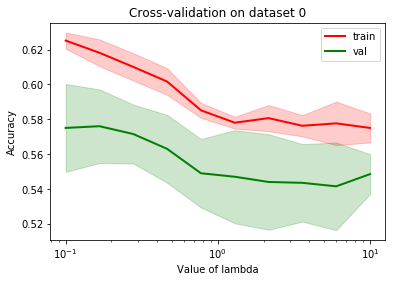

In [ ]:
d = 0
plt.figure()
lineplotCI(
    lambd_range,
    acc_train[d].mean(axis=1),
    acc_train[d].mean(axis=1) + acc_train[d].std(axis=1),
    acc_train[d].mean(axis=1) - acc_train[d].std(axis=1),
    c='r',
    log=True
)
lineplotCI(
    lambd_range,
    acc_val[d].mean(axis=1),
    acc_val[d].mean(axis=1) + acc_val[d].std(axis=1),
    acc_val[d].mean(axis=1) - acc_val[d].std(axis=1),
    c='g',
    log=True
)
plt.legend(['train', 'val'])
plt.xlabel('Value of lambda')
plt.ylabel('Accuracy')
plt.title('Cross-validation on dataset {}'.format(d))
plt.show()

In [ ]:
best_lambd = [
    lambd_range[np.argmax(np.mean(acc_val[d], axis=1))]
    for d in range(3)
]
print(best_lambd)

[0.16681005372000587, 0.16681005372000587, 0.16681005372000587]


### 2.2 Grid search on lambda & sigma for the gaussian kernel

In [ ]:
sigma_range = np.logspace(-1, 1, 5)
lambd_range = np.logspace(-1, 1, 5)
tuple_range = list(itertools.product(lambd_range, sigma_range))

acc_train = np.zeros((3, len(tuple_range), kfold))
acc_val = np.zeros((3, len(tuple_range), kfold))

for d, data in enumerate(dataset):
    Xtr, Ytr, _ = data
    for i in tqdm.trange(len(tuple_range), desc="Testing (lambd, sigma) for dataset {}".format(d+1)):
        lambd, sigma = tuple_range[i]
        acc_train[d, i], acc_val[d, i] = cross_validate(
            Xtr, Ytr,
            gauss(sigma), lambd,
            shuffle=True, kfold=kfold
        )

Testing (lambd, sigma) for dataset 3:  20%|██        | 5/25 [00:10<00:40,  2.03s/it]

In [ ]:
best_tuple = [
    tuple_range[np.argmax(np.mean(acc_val[d], axis=1))]
    for d in range(3)
]
best_lambd = [bt[0] for bt in best_tuple]
best_sigma = [bt[1] for bt in best_tuple]

## 3. Final predictions

In [ ]:
Ypred = []
lambd = 0.

for k in [0, 1, 2]:
    print("\nDATASET {}\n".format(k))

    Xtr, Ytr, Xte = dataset[k]
    
    f = compute_predictor(Xtr, Ytr, gauss(best_sigma[k]), best_lambd[k])
    print(np.mean(Ytr == f(Xtr)))
    Yte = f(Xte)
    
    Ypred.extend(list(((Yte + 1) / 2).astype(int)))
    
Ypred = pd.Series(
    index=np.arange(len(Ypred)),
    data=Ypred
)
Ypred.index.name = "Id"
Ypred.name = "Bound"
Ypred.to_csv("Ypred.csv", header=True)